# LSTM model for multivariate Time Series

In [2]:
rm(list=ls())
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

In [3]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2

In [4]:
require(tensorflow)
require(keras)

Loading required package: tensorflow

Loading required package: keras



In [5]:
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
colnames(df.ts) <-lab.to.num$num

In [6]:

df.train <-df.ts %>% as.data.frame


In [7]:
#-----------------------------
# Scaled the train sample and get the sample factor parmas: mean + sd
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))

In [8]:
scaled_train   

1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
1.258286041,-2.1070676,0.57533001,2.08893236,0.83297113,-1.70108329,-2.06805496,-1.6105164,-1.60977544,2.67530080,⋯,1.153590558,-0.59215079,0.6104969,0.5768366,2.20804706,0.36963901,0.83258771,-1.75151624,0.16352704,-1.38275175
1.174678995,-2.1722515,1.67119669,2.08893236,1.03476764,-2.57906177,-1.98483343,-1.4204850,-1.64840232,2.24205371,⋯,1.245236282,0.15582916,1.0988944,-0.1223593,2.38540024,0.81768629,0.96833571,-0.19714036,0.90381838,-1.18089018
1.105006457,-2.0418838,1.67119669,2.08893236,0.02578511,-2.57906177,-0.98617510,-1.0404221,-1.45526790,2.53088511,⋯,2.894859324,-0.59215079,1.0988944,0.5768366,1.14392799,1.26573356,1.19458237,-1.06910731,0.51709903,-0.37344390
1.091071949,-2.6285383,1.67119669,2.08893236,0.87781480,-1.70108329,-1.73516885,-1.2304536,-1.33938724,2.67530080,⋯,0.741184797,0.15582916,1.0988944,0.5768366,0.07980893,1.26573356,1.14933303,-0.04549393,0.67178677,-0.97902861
1.063202934,0.3699183,1.12326335,1.83024105,0.49664362,0.49386289,-0.81973205,-1.4204850,-1.45526790,1.51997522,⋯,0.832830522,-0.09349749,1.5872918,-0.4719573,-0.09754425,1.26573356,0.96833571,-0.84163767,-0.17899582,-1.38275175
1.035333919,0.4351021,1.12326335,1.31285842,0.74328379,0.05487365,-0.73651052,-1.2304536,-1.22350659,0.94231243,⋯,0.878653384,-0.34282414,0.1220994,-0.4719573,0.96657482,0.81768629,1.19458237,0.40944535,0.38450953,-1.78647489
0.965661381,0.3047345,1.67119669,2.34762368,-0.53476074,0.05487365,-0.81973205,-1.6105164,-1.14625282,0.79789673,⋯,2.482453563,-1.34013074,0.6104969,0.5768366,0.61186846,0.81768629,1.37557969,-0.99328410,0.24087091,-1.18089018
0.937792365,0.3047345,0.57533001,0.53678448,0.36211262,-0.82310482,-0.81973205,-1.4204850,-1.03037216,0.22023394,⋯,0.466247624,0.15582916,-0.3662981,0.5768366,0.61186846,1.71378084,0.92308637,-0.61416803,0.24087091,-0.77716704
0.826316304,0.4351021,-0.52053667,-0.23928947,0.51906546,-0.82310482,-0.65328899,-1.2304536,-1.14625282,-0.79067595,⋯,0.282956175,-0.84147744,-0.8546956,0.5768366,0.07980893,2.16182812,0.69683971,-1.10701892,0.27401829,-0.57530547
0.798447289,0.3699183,-0.52053667,-0.23928947,0.60875279,-0.38411558,-0.48684594,-1.0404221,-0.79861085,-0.50184455,⋯,0.282956175,-0.84147744,0.1220994,0.5768366,0.07980893,1.48975720,0.65159038,0.44735696,0.84857276,-0.57530547


In [9]:
#----------------
# We d like to do a 6 Quarter forecast,
# We need to base each prediction on 6 points
prediction <- 6
lag <- prediction

In [10]:
scaled_train %>%dim
length(scaled_train)

[1] 40 26

[1] 1040

In [11]:

x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

In [12]:
cat("Shape de  X_train :",x_train_data%>% dim)

Shape de  X_train : 29 156

In [13]:
x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)


In [14]:
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)

In [15]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test[,1]

In [16]:
x_test

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [17]:
x_pred_arr <- array(
    data=x_test,
    dim=c(1,lag,1)
)

In [17]:
cat("\nX test scaled :",x_test_scaled)


X test scaled : -1.431074 -1.472877 -1.584354 -1.667961 -1.849109 -1.904847

<hr>

# Construct LSTM model

In [44]:
x_train_arr %>%dim
y_train_arr %>%dim

[1]  29 156   1

[1] 29  6  1

In [45]:
LSTM_model <- keras_model_sequential()

LSTM_model%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,156,ncol(x_train_arr)),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=1))

In [46]:
LSTM_model %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_7 (LSTM)                      (1, 156, 50)                    41400       
 dropout_7 (Dropout)                (1, 156, 50)                    0           
 lstm_6 (LSTM)                      (1, 156, 50)                    20200       
 dropout_6 (Dropout)                (1, 156, 50)                    0           
 time_distributed_3 (TimeDistribute  (1, 156, 1)                    51          
 d)                                                                             
Total params: 61,651
Trainable params: 61,651
Non-trainable params: 0
________________________________________________________________________________


In [51]:
x_train_arr %>%dim # On voudrait plutot un truc de dim : 29 * 6* 26
y_train_arr %>%dim

[1]  29 156   1

[1] 29  6  1

In [48]:
LSTM_model %>% keras::fit(
    x=x_train_arr,
    y=y_train_arr,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: in user code:
<... omitted ...>/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/home/jay_boo/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jay_boo/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "lstm_7" is incompatible with the layer: expected shape=(1, None, 156), found shape=(1, 156, 1)
    
    Call arguments received by layer "sequential_3" (type Sequential):
      • inputs=tf.Tensor(shape=(1, 156, 1), dtype=float32)
      • training=True
      • mask=None

See `reticulate::py_last_error()` for details


In [18]:

x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(29-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+29-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array


In [19]:

y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array


In [20]:

x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 29  6 26

[1] 29  6 26

In [21]:
LSTM_model <- keras_model_sequential()

LSTM_model%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

Loaded Tensorflow version 2.9.1



In [22]:
LSTM_model %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 6, 50)                      15400       
 dropout_1 (Dropout)                (1, 6, 50)                      0           
 lstm (LSTM)                        (1, 6, 50)                      20200       
 dropout (Dropout)                  (1, 6, 50)                      0           
 time_distributed (TimeDistributed)  (1, 6, 26)                     1326        
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [23]:
LSTM_model %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [24]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [25]:
x_test_scaled %>%dim
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

[1]  6 26

In [26]:
x_test_array %>%dim

[1]  1  6 26

In [27]:
LSTM_forecast <- LSTM_model %>% predict(x_test_array,batch_size=1)
LSTM_forecast %>%dim

[1]  1  6 26

In [28]:
LSTM_forecast[,,1] 

[1] -1.398210 -1.389631 -1.403860 -1.384493 -1.417427 -1.429514

In [29]:
# Unscale prediction
for (i in 1: dim(LSTM_forecast)[3]){
    LSTM_forecast[,,i] <- LSTM_forecast[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}

In [30]:
LSTM_forecast[,,1]

[1] 1099.358 1099.974 1098.953 1100.343 1097.979 1097.112

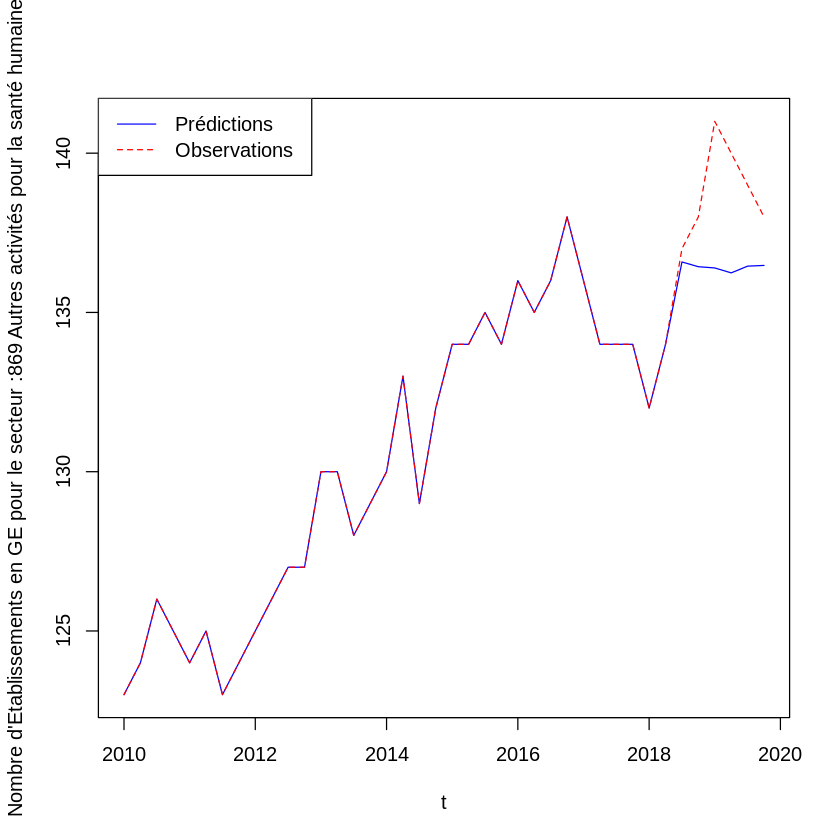

In [49]:
index_secteur <- 8
pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
pred <-ts(pred, start=c(2010,1),frequency=4)
obs <- df.ts[,index_secteur]

plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(1,2),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(1,2),
    lwd=1
)

<hr>

## Save results

In [52]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_non_stable/",index_secteur,".png",sep=""))
    pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        main=paste("Predictions LSTM non stable vs observations \n secteur : ",lab.to.num$lab[index_secteur],sep=""),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

    )
    legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
    dev.off()
}

In [35]:
#----------------------
#Save models
save_model_tf(LSTM_model,"models/LSTM_non_stable")